In [1]:
import numpy as np
import pandas as pd
pd.set_option('precision', 3)
from itertools import compress
import copy, sys, os, warnings
import matplotlib.pyplot as plt
from pyirr import intraclass_correlation
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold, permutation_test_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, confusion_matrix, make_scorer
from scipy.stats import spearmanr, mannwhitneyu
from compare_auc_delong import delong_roc_test

oldPath = os.path.join(os.path.expanduser('~'), 'Documents/GitHub/icrpythonradiomics/machineLearning')
if os.path.exists(oldPath):
    sys.path.remove(oldPath)
sys.path.append(os.path.join(os.path.expanduser('~'), 'Documents/git/git_icrpythonradiomics/machineLearning'))
from featureSelection import featureSelection_correlation as featSelCorr

dataFolder = os.path.join(os.path.expanduser('~'), 'Dropbox (ICR)/CLINMAG/Radiomics/ECE_Prostate_Semantic/ECE_Semantic_Data')

# validation parameters
n_splits = 10
n_repeats = 20

permutationTest = False
n_permutations = 100


In [2]:
def confusion_matrix_thresholds(yTrue, yScore, thresholds):
    tnArr, fpArr, fnArr, tpArr = [], [], [], []
    nSamples = len(yTrue)
    for thresh in thresholds:
        tn, fp, fn, tp = confusion_matrix(yTrue, yScore>thresh).ravel()
        tnArr.append(tn)
        fpArr.append(fp)
        fnArr.append(fn)
        tpArr.append(tp)
    return np.array(tnArr), np.array(fpArr), np.array(fnArr), np.array(tpArr)

In [3]:
def calculate_fnr(y_true, y_pred, pt=0):

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred > pt).ravel()
    return fn/(fn + tp)


def calculate_fpr(y_true, y_pred, pt=0):

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred > pt).ravel()
    return fp/(fp + tn)


def calculate_net_benefit_score(y_true, y_pred, pt=0):
    _, fp, _, tp = confusion_matrix(y_true, y_pred > pt).ravel()
    net_benefit = (tp - fp * (pt / (1 - pt))) / len(y_true)
    return net_benefit


def unpack_scorers(cvr):

    thresh_FNR, thresh_FPR, thresh_DCA, value_DCA, value_FNR, value_FPR = [], [], [], [], [], []
    
    for key, value in cvr.items():
        if 'test_FNR' in key:
            thresh_FNR.append(float(key.replace('test_FNR_','')))
            value_FNR.append(np.mean(value))
        if 'test_FPR' in key:
            thresh_FPR.append(float(key.replace('test_FPR_','')))
            value_FPR.append(np.mean(value))
        if 'test_DCA' in key:
            thresh_DCA.append(float(key.replace('test_DCA_','')))
            value_DCA.append(np.mean(value))

    idxFNR = np.argsort(thresh_FNR)
    idxFPR = np.argsort(thresh_FPR)
    idxDCA = np.argsort(thresh_DCA)

    FNR = {'thresholds': [thresh_FNR[idx] for idx in idxFNR],
           'values': [value_FNR[idx] for idx in idxFNR]}
    
    FPR = {'thresholds': [thresh_FPR[idx] for idx in idxFPR],
           'values': [value_FPR[idx] for idx in idxFPR]}

    DCA = {'thresholds': [thresh_DCA[idx] for idx in idxDCA],
           'values': [value_DCA[idx] for idx in idxDCA]}
    
    return FNR, FPR, DCA

# Make dictionary of scorers, each of which will compute one point on the FNR and FPR curves.
# The dictionary key is used to keep track of the threshold value that was used.
scorers = {}

# Don't use 0 and 1 as endpoints as this causes numerical underflow.
ptArr = np.round(np.linspace(0, 1, 101),2)
ptArr[0] = np.round(0.0001,4)
ptArr[-1] = np.round(0.9999,4)

for pt in ptArr:
    scorers['FNR_' + str(pt)] = make_scorer(calculate_fnr, pt = pt, needs_proba=True)
    scorers['FPR_' + str(pt)] = make_scorer(calculate_fpr, pt = pt, needs_proba=True)
    scorers['DCA_' + str(pt)] = make_scorer(calculate_net_benefit_score, pt = pt, needs_proba=True)

# standard scorers    
scorers['roc_auc'] = 'roc_auc'
scorers['accuracy'] = 'accuracy'
scorers['f1'] = 'f1'

## Load two reader semantic data (for computing ICCs) 

In [4]:
twoReaderFile = os.path.join(dataFolder, 'GG_MG.xlsx')

# read spreadsheet
df = pd.read_excel(twoReaderFile, sheet_name='GG_MG', engine='openpyxl')

# remove features, as with the discovery/test data
df.drop(['IndexLesion_GG', 'IndexLesionMG', 'GlobalStageGG', 'GlobalStageMG'], axis=1, inplace=True)

# remove rows with missing data - need to check that this leaves the same patients for dfGG as in the discovery data set
df.dropna(inplace=True)

# split to each reader
dfGG = df.filter(regex = 'GG|PID', axis = 1)
dfMG = df.filter(regex='MG|PID', axis=1)

# match column names by removing subscripts
dfGG = dfGG.rename(columns=lambda x: x.replace('_GG','').replace('GG',''))
dfMG = dfMG.rename(columns=lambda x: x.replace('_MG','').replace('MG',''))

# change some column names to match the discovery/test data sets
renameDict = {'LocIndexL':'AnatDev01',
              'LocAnat':'AnatDev02',
              'Division':'AnatDev03',
              'DivisionLat':'AnatDev04',
              'LesionSize':'MajorLengthIndex',
              'SmoothCapsularBulgin':'SmoothCapsularBulging',
              'UnsharpMargins':'UnsharpMargin',
              'irregularContour':'IrregularContour',
              'BlackEstrition':'BlackEstritionPeripFat',
              'measurableECE':'MeasurableECE',
              'retroprostaticAngleObl':'RetroprostaticAngleOblit'}
dfGG.rename(renameDict, axis=1, inplace=True)
dfMG.rename(renameDict, axis=1, inplace=True)

# highsignalT1FS is missing from this spreadsheet, so fill in with default value.
# Fortunately, this feature is not selected in the final model, but we need it there for compatibility.
dfGG.loc[:, 'highsignalT1FS'] = 0
dfMG.loc[:, 'highsignalT1FS'] = 0

iccDict = {}
for col in dfGG.drop(['PID', 'highsignalT1FS'], axis=1):
    data = np.stack((dfGG[col], dfMG[col]), axis=1)
    iccDict['semantic_' + col] = intraclass_correlation(data, "twoway", "agreement").value

## Read and prepare radiomics data (discovery and test) 

In [5]:
radiomicsFile = os.path.join(dataFolder, 'radiomicFeatures__202209271126.csv')

dfRad = pd.read_csv(radiomicsFile)
dfRad.drop(list(dfRad.filter(regex = 'source')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'diagnostics')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'histogram')), axis = 1, inplace = True)

# remove feature sets we don't want to use and remove string from the one that is left
dfRad.drop(list(dfRad.filter(regex = 'noNormalize|maskNormalize')), axis = 1, inplace = True)
dfRad = dfRad.rename(columns=lambda x: x.replace('normalized_',''))

# To match the semantic data file
dfRad['StudyPatientName'] = dfRad['StudyPatientName'].str.replace('_',' ')

# sensible prefix 
dfRad = dfRad.rename(columns=lambda x: x.replace('original','radiomics'))

# split off the repro rows
dfRep1 = dfRad.loc[dfRad.StudyPatientName.str.contains('rep'),:].copy()
dfRep1['StudyPatientName'] = dfRep1['StudyPatientName'].str.replace(' repro','')
dfRep1.sort_values('StudyPatientName', axis=0, inplace=True)
dfRep1.reset_index(inplace=True, drop=True)

# remove repro from main data frame
dfRad = dfRad.loc[~dfRad.StudyPatientName.str.contains('rep'),:]
dfRad.reset_index(inplace=True, drop=True)

# main data rows for same patients as repro
dfRep0 = dfRad.loc[dfRad['StudyPatientName'].isin(dfRep1['StudyPatientName'])].copy()
dfRep0.sort_values('StudyPatientName', axis=0, inplace=True)
dfRep0.reset_index(inplace=True, drop=True)

for col in dfRep1.drop('StudyPatientName', axis=1):
    data = np.stack((dfRep0[col], dfRep1[col]), axis=1)
    iccDict[col] = intraclass_correlation(data, "twoway", "agreement").value


## Read and prepare semantic data (discovery and test)

In [6]:
discoveryFile = os.path.join(dataFolder, 'discovery.csv')
externalTestFile = os.path.join(dataFolder, 'external.csv')
    
# load data
dfTrain = pd.read_csv(discoveryFile)
dfTest  = pd.read_csv(externalTestFile)

# drop features we are not going to use for classification
dfTrain.drop(['Gleason biopsy','TumorGradeMRI'], inplace=True, axis=1)
dfTest.drop(['Gleason biopsy','TumorGradeMRI'], inplace=True, axis=1)

# make these features binary 0/1
toBinary = ['SmoothCapsularBulging' ,'CapsularDisruption', 'UnsharpMargin', 'IrregularContour', 'BlackEstritionPeripFat', 'MeasurableECE', 'RetroprostaticAngleOblit', 'highsignalT1FS']
for tb in toBinary:
    dfTrain[tb]  = dfTrain[tb].map(dict(YES=1, NO=0))
    dfTest[tb] = dfTest[tb].map(dict(YES=1, NO=0))

# is missing in test and training, so replace both with median from the training data
psaTrainMedian = np.nanmedian(np.array(dfTrain.PSA))
dfTrain.PSA.fillna(psaTrainMedian, inplace=True)
dfTest.PSA.fillna(psaTrainMedian, inplace=True)

# this feature is not selected in the semantic model, so this has no effect
# fill in with the most common value
dfTest.highsignalT1FS.fillna(0, inplace=True)

# add string to names for easy manipulation of groups
clinicalFeatures = ['GleasonBinary', 'ProstateVolume', 'PSA', 'IndLesPIRADS_V2']
semanticFeatures = list(set(dfTrain.columns) - set(clinicalFeatures) - set(['PID', 'ECE_Pathology']))
dfTrain = dfTrain.rename(columns=lambda x: 'clinical_' + x if x in clinicalFeatures else x)
dfTest = dfTest.rename(columns=lambda x: 'clinical_' + x if x in clinicalFeatures else x)
dfTrain = dfTrain.rename(columns=lambda x: 'semantic_' + x if x in semanticFeatures else x)
dfTest = dfTest.rename(columns=lambda x: 'semantic_' + x if x in semanticFeatures else x)

# merge radiomics 
dfTrain = dfTrain.merge(dfRad, left_on='PID', right_on='StudyPatientName')
dfTest = dfTest.merge(dfRad, left_on='PID', right_on='StudyPatientName')
dfTrain = dfTrain.drop(['PID', 'StudyPatientName'], axis=1)
dfTest = dfTest.drop(['PID', 'StudyPatientName'], axis=1)


## Main model fitting function 

In [7]:
def jitterColumns(df, scale):
    for col in df:
        df[col] = df[col] + np.random.normal(loc=0, scale=scale*np.std(df[col]), size=df[col].shape)
    return df

def replicateDf(df, N):
    dfOut = df.copy()
    for n in range(N-1):
        dfOut = pd.concat([dfOut, df], axis=0)
    return dfOut

In [8]:
def fitModel(dfTrain, dfTest, pipeline, coefDisplayFunction=None, keepRegex=None, permutationTest=False, jitterTestData=False):

    # reproducible execution
    seed = 42
    np.random.seed(seed)

    # get training and test data
    XTrain = dfTrain.drop('ECE_Pathology', axis=1)
    XTest = dfTest.drop('ECE_Pathology', axis=1)
    yTrain = dfTrain.ECE_Pathology
    yTest = dfTest.ECE_Pathology
    
    # keep features as indicated
    if keepRegex is not None:
        XTrain = XTrain.filter(regex = keepRegex)
        XTest = XTest.filter(regex = keepRegex)

    # make sure correlationSelector will not remove any clinical or semantic features
    if pipeline.steps[0][0] == 'correlationSelector':
        pipeline.steps[0][1].namedColumnsKeep = [x for x in XTrain.columns if 'clinical' in x or 'semantic' in x]
        
    # drop low variance radiomics features
    CoV = pd.DataFrame(XTrain.apply(lambda x: np.std(x)/np.mean(x), axis=0))
    lowVarianceFeatures = CoV.loc[CoV.loc[:,0]<0.01,:].index.values.tolist()
    lowVarianceFeatures = [x for x in lowVarianceFeatures if 'clinical' not in x and 'semantic' not in x]
    XTrain.drop(lowVarianceFeatures, axis = 1, inplace = True)
    XTest.drop(lowVarianceFeatures, axis = 1, inplace = True)

    # fit to all data
    pipeline.fit(XTrain, yTrain)

    # cross-validate
    outer_cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    cv_result = cross_validate(pipeline, 
                               XTrain, 
                               yTrain, 
                               cv=outer_cv, 
                               scoring=scorers,
                               return_estimator=True, 
                               verbose=0, 
                               n_jobs=-1)

    # print CV scores
    AUC_CV = np.mean(cv_result['test_roc_auc'])
    Accuracy_CV = np.mean(cv_result['test_accuracy'])
    F1_CV = np.mean(cv_result['test_f1'])
    print('AUCROC   (CV) = ' + str(AUC_CV.round(3)))
    print('Accuracy (CV) = ' + str(Accuracy_CV.round(3)))
    print('F1       (CV) = ' + str(F1_CV.round(3)))

    FNR, FPR, DCA = unpack_scorers(cv_result)

    # permutation testing
    if permutationTest:
        outer_cv.n_repeats = 1

        warnings.simplefilter("ignore")
        os.environ["PYTHONWARNINGS"] = "ignore"
        #
        scoreDirect, perm_scores, pValueDirect = permutation_test_score(pipeline, 
                                                                        XTrain, 
                                                                        yTrain, 
                                                                        scoring="roc_auc",
                                                                        cv=outer_cv, 
                                                                        n_permutations=n_permutations,
                                                                        verbose=0, n_jobs=-1)
        #
        warnings.simplefilter('default')
        os.environ["PYTHONWARNINGS"] = 'default'

        # pValueDirect is computed using scoreDirect and assumes only one outer CV run
        # We have used repeated outer CV, so the following code correctly computes the p-value of our repeated CV performance estimate
        # Actually, it doesn't seem to make much difference, so am relaxed about that.

        p_values = []
        scores_roc_auc = np.mean(np.reshape(cv_result['test_roc_auc'], (n_repeats, -1)), axis=1)
        for score in scores_roc_auc:
            p_values.append((np.count_nonzero(perm_scores >= score) + 1) / (n_permutations + 1))
        pValue_CV = np.mean(p_values)
        print('p-value       = ' + str(pValue_CV.round(4)))
    else:
        pValue_CV = None
    
    # replicate and add jitter to test data to give smoother roc and DCA curves
    if jitterTestData:
        XTest = replicateDf(XTest, 20)
        yTest = replicateDf(yTest, 20)
        XTest = jitterColumns(XTest, 0.1)

    # get scores and predicted class info
    test_score = pipeline.predict_proba(XTest)[:, 1]
    test_class = pipeline.predict(XTest)

    # test scores from main model
    testAUROC = roc_auc_score(yTest, test_score)
    testAccuracy = accuracy_score(yTest, test_class)
    testF1 = f1_score(yTest, test_class)

    pValueTest = mannwhitneyu(test_score[yTest==0], test_score[yTest==1], alternative='two-sided').pvalue

    # print the test performance metrics
    print('\nAUCROC   (test) = ' + str(np.round(testAUROC,3)))
    print('Accuracy (test) = ' + str(np.round(testAccuracy,3)))
    print('F1       (test) = ' + str(np.round(testF1,3)))
    print('p-value  (test) = ' + str(np.round(pValueTest, 6)))

    if coefDisplayFunction is not None:
        dfCoefResults = coefDisplayFunction(pipeline, XTrain.columns, cv_result)

    out = {'test_AUC':testAUROC,
           'test_score':test_score,
           'test_class':test_class,
           'test_accuracy':testAccuracy,
           'test_f1':testF1,
           'test_pValue':pValueTest,
           'AUC_CV':AUC_CV,
           'Accuracy_CV':Accuracy_CV,
           'F1_CV':F1_CV,
           'pValue_CV':pValue_CV,
           'FNR_CV':FNR,
           'FPR_CV':FPR,
           'DCA_CV':DCA,
           'yTest':yTest}
    
    return out



## Three logistic regression pipelines 

In [9]:
# basic logistic regression, no regularisation
pipelineLRsimple = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('lr', LogisticRegression(penalty='none'))])

# logistic regression with lasso
pipelineLRlasso = Pipeline(steps=[('scaler', StandardScaler()), 
                                  ('lr', LogisticRegressionCV(Cs=20, 
                                                              cv=10, 
                                                              solver="liblinear",
                                                              max_iter=10000, 
                                                              penalty='l1',
                                                              random_state=42))])

# logistic regression with lasso, preceded by correlation feature reduction
# fitModel function will modify pipeline to make sure the clinical and semantic features are not affected by
# correlation feature reduction
pipelineCfrLRlasso = Pipeline([('correlationSelector', featSelCorr(threshold=0.9,
                                                                   exact=False,
                                                                   featureGroupHierarchy=['shape_MeshVolume',
                                                                                          'shape',
                                                                                          'firstorder'])),
                               ('scaler', StandardScaler()),
                               ('lr', GridSearchCV(estimator=LogisticRegression(solver="liblinear", 
                                                                                max_iter=10000, 
                                                                                penalty='l1'), 
                                                   param_grid={'C':np.logspace(np.log10(0.05), np.log10(50), 10)}, 
                                                   cv=StratifiedKFold(n_splits=5), 
                                                   refit=True, 
                                                   verbose=0, 
                                                   scoring='neg_log_loss', 
                                                   n_jobs=1))])


## Functions to display non-zero logistic regression coeffients for the pipelines

In [10]:
def coefDispFunLRsimple(pipeline, featureNames, dummy):
    display(pd.DataFrame({'Feature':[x.replace('clinical_','') for x in featureNames], 
                          'Coefficient':np.squeeze(pipeline._final_estimator.coef_)}).style.hide_index())

def coefDispFunLRlasso(pipeline, featureNames, cv_result):

    # get frequency that features are non-zero across the repeated cv splits
    coef_cv = np.zeros((len(cv_result['estimator']), len(featureNames)))
    for n, res in enumerate(cv_result['estimator']):
        coef_cv[n, :] = res._final_estimator.coef_
    coef_freq = np.sum(coef_cv != 0, axis=0) / (n_repeats * n_splits)

    # put icc values in array for including in DataFrame
    iccList = []
    for feat in featureNames:
        if feat in iccDict:
            iccList.append(iccDict[feat])
        else:
            iccList.append('-')

    # display sorted coefficients and selection frequency
    coeffs = np.squeeze(pipeline._final_estimator.coef_)
    dfCoefResults = pd.DataFrame({'Feature': featureNames, 'Coeff': coeffs, 'Freq': coef_freq, 'ICC':iccList})
    dfCoefResults.sort_values(by=['Coeff', 'Freq'], key=abs, inplace=True, ascending=False)
    display(dfCoefResults.loc[dfCoefResults.Coeff != 0, :].style.hide_index())

def coefDispFunCfrLRlasso(pipeline, featureNames, cv_result):
    
    # get frequency that features are non-zero across the repeated cv splits
    coef_cv = np.zeros((len(cv_result['estimator']), len(featureNames)))
    fs_mask = np.zeros((len(cv_result['estimator']), len(featureNames)))
    for n, res in enumerate(cv_result['estimator']):
        fs_mask[n, :] = res.steps[0][1].mask_
        coef_cv[n, res.steps[0][1].mask_] = res._final_estimator.best_estimator_.coef_
    coef_freq = np.sum(coef_cv != 0, axis=0) / (n_repeats * n_splits)

    # put icc values in array for including in DataFrame
    iccList = []
    for feat in featureNames:
        if feat in iccDict:
            iccList.append(iccDict[feat])
        else:
            iccList.append('-')

    # display sorted coefficients and selection frequency
    coeffs = np.zeros(len(featureNames))
    coeffs[pipeline.steps[0][1].mask_] = np.squeeze(pipeline._final_estimator.best_estimator_.coef_)

    dfCoefResults = pd.DataFrame({'Feature': featureNames, 'Coeff': coeffs, 'Freq': coef_freq, 'ICC':iccList})
    dfCoefResults.sort_values(by=['Coeff', 'Freq'], key=abs, inplace=True, ascending=False)
    display(dfCoefResults.loc[dfCoefResults.Coeff != 0, :].style.hide_index())


## Fit models to four combinations of input features 

In [11]:
jitterTestData = True

print('Clinical features\n')
rc = fitModel(dfTrain,
              dfTest,
              pipelineLRsimple, 
              coefDisplayFunction=coefDispFunLRsimple, 
              keepRegex='clinical', 
              permutationTest=permutationTest,
              jitterTestData=jitterTestData)
rc['label'] = 'Clinical'

print('\n\n\nClinical + Semantic features\n')
rcs = fitModel(dfTrain,
               dfTest,
               pipelineLRlasso, 
               coefDisplayFunction=coefDispFunLRlasso, 
               keepRegex='clinical|semantic', 
               permutationTest=permutationTest,
               jitterTestData=jitterTestData)
rcs['label'] = 'Clinical + Semantic'

print('\n\n\nClinical + Radiomic features\n')
rcr = fitModel(dfTrain,
               dfTest,
               pipelineCfrLRlasso, 
               coefDisplayFunction=coefDispFunCfrLRlasso, 
               keepRegex='clinical|radiomic', 
               permutationTest=permutationTest,
               jitterTestData=jitterTestData)
rcr['label'] = 'Clinical + Radiomic'

print('\n\n\nClinical + Semantic + Radiomic features\n')
rcsr = fitModel(dfTrain,
                dfTest,
                pipelineCfrLRlasso, 
                coefDisplayFunction=coefDispFunCfrLRlasso, 
                keepRegex='clinical|semantic|radiomic', 
                permutationTest=permutationTest,
                jitterTestData=jitterTestData)
rcsr['label'] = 'Clinical + Semantic + Radiomic'

Clinical features

AUCROC   (CV) = 0.798
Accuracy (CV) = 0.796
F1       (CV) = 0.59

AUCROC   (test) = 0.767
Accuracy (test) = 0.686
F1       (test) = 0.55
p-value  (test) = 0.0


Feature,Coefficient
GleasonBinary,1.180
ProstateVolume,-0.341
PSA,0.081
IndLesPIRADS_V2,0.293





Clinical + Semantic features

AUCROC   (CV) = 0.837
Accuracy (CV) = 0.849
F1       (CV) = 0.622

AUCROC   (test) = 0.899
Accuracy (test) = 0.745
F1       (test) = 0.462
p-value  (test) = 0.0


Feature,Coeff,Freq,ICC
semantic_MeasurableECE,0.662,1.000,0.787
clinical_GleasonBinary,0.297,0.760,-
semantic_IrregularContour,0.213,0.760,0.417
semantic_CapsularDisruption,0.098,0.715,0.352





Clinical + Radiomic features

AUCROC   (CV) = 0.82
Accuracy (CV) = 0.813
F1       (CV) = 0.601

AUCROC   (test) = 0.808
Accuracy (test) = 0.755
F1       (test) = 0.527
p-value  (test) = 0.0


Feature,Coeff,Freq,ICC
clinical_GleasonBinary,0.745,1.000,-
radiomics_firstorder_90Percentile,-0.465,0.995,0.935
radiomics_firstorder_Range,0.264,0.865,0.679
radiomics_shape_MeshVolume,0.214,0.910,0.904
radiomics_gldm_DependenceVariance,0.117,0.640,0.656
clinical_ProstateVolume,-0.090,0.900,-
radiomics_glcm_Correlation,0.005,0.230,0.726
radiomics_glcm_MCC,0.002,0.345,0.443





Clinical + Semantic + Radiomic features

AUCROC   (CV) = 0.875
Accuracy (CV) = 0.843
F1       (CV) = 0.618

AUCROC   (test) = 0.94
Accuracy (test) = 0.763
F1       (test) = 0.516
p-value  (test) = 0.0


Feature,Coeff,Freq,ICC
semantic_MeasurableECE,0.784,1.000,0.787
clinical_GleasonBinary,0.490,1.000,-
semantic_IrregularContour,0.385,1.000,0.417
semantic_CapsularDisruption,0.248,1.000,0.352
semantic_AnatDev03,0.115,0.850,0.409
radiomics_firstorder_90Percentile,-0.073,0.655,0.935
radiomics_firstorder_Skewness,0.068,0.545,0.283
radiomics_firstorder_Range,0.061,0.535,0.679
radiomics_gldm_LargeDependenceLowGrayLevelEmphasis,0.043,0.680,0.197
semantic_RetroprostaticAngleOblit,0.023,0.650,0.479


## Make some plots 

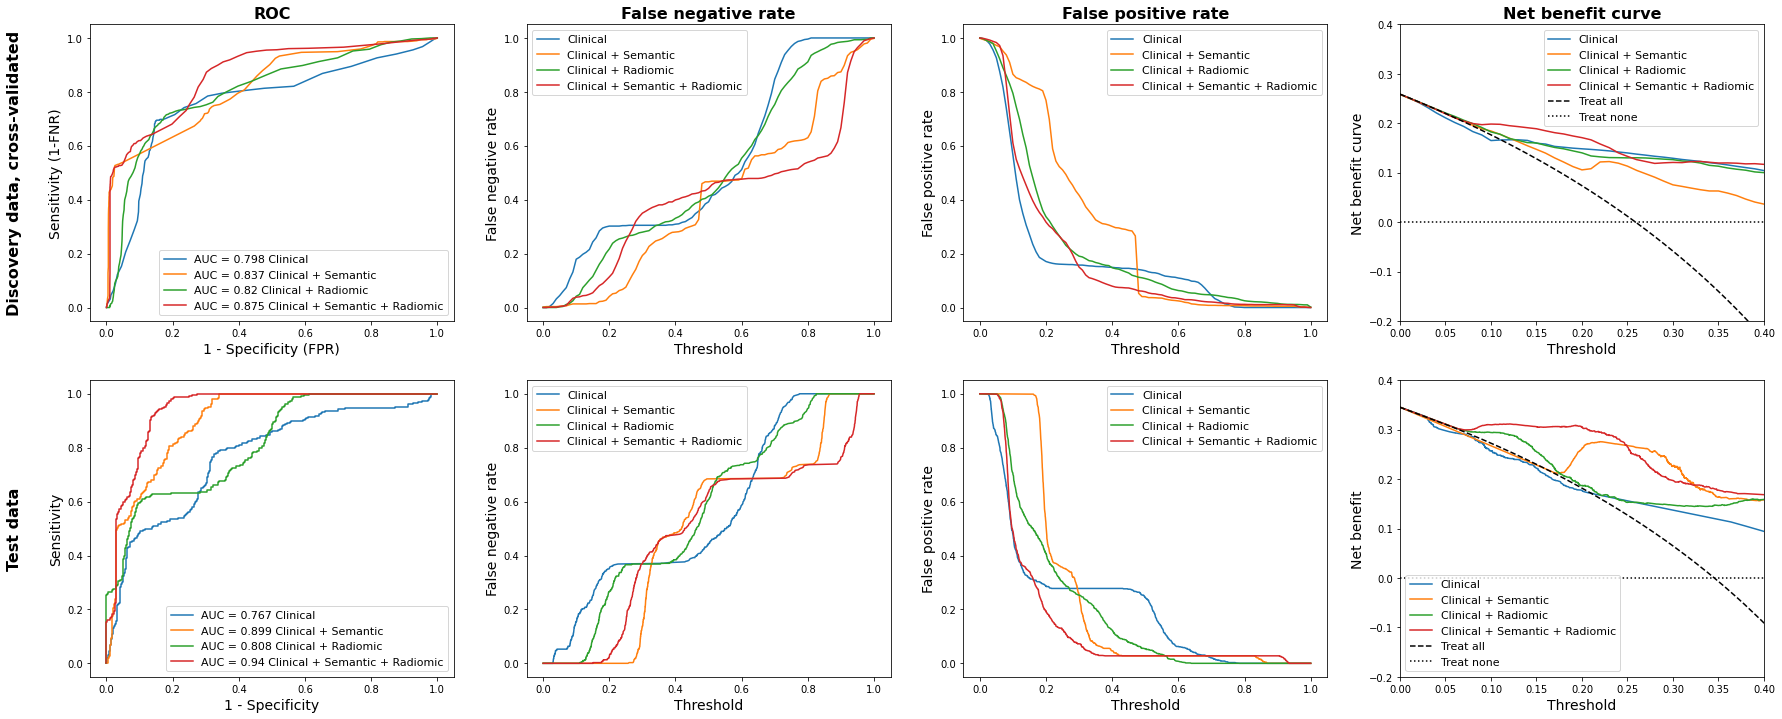

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(30,12))
ax = ax.ravel()

# discovery data plots

models = [rc, rcs, rcr, rcsr]

# ROC
for r in models:
    ax[0].plot(r['FPR_CV']['values'], 
               [1-x for x in r['FNR_CV']['values']], 
               label = 'AUC = ' + str(np.round(r['AUC_CV'],3)) + ' ' + r['label'])
ax[0].set_xlabel('1 - Specificity (FPR)', fontsize=14)
ax[0].set_ylabel('Sensitivity (1-FNR)', fontsize=14)
ax[0].set_title('ROC', fontsize=16, fontweight='bold')
ax[0].legend(fontsize=11)
ax[0].text(-0.3, 0.5, 'Discovery data, cross-validated', fontsize=16, fontweight='bold', rotation=90, verticalalignment='center')


# FNR
for r in models:
    ax[1].plot(r['FNR_CV']['thresholds'], r['FNR_CV']['values'], label=r['label'])
ax[1].set_title('False negative rate', fontsize=16, fontweight='bold')
ax[1].legend(fontsize=11)
ax[1].set_xlabel('Threshold', fontsize=14)
ax[1].set_ylabel('False negative rate', fontsize=14)

# FPR
for r in models:
    ax[2].plot(r['FPR_CV']['thresholds'], r['FPR_CV']['values'], label=r['label'])
ax[2].set_title('False positive rate', fontsize=16, fontweight='bold')
ax[2].legend(fontsize=11)
ax[2].set_xlabel('Threshold', fontsize=14)
ax[2].set_ylabel('False positive rate', fontsize=14)

# DCA
for r in models:
    ax[3].plot(r['DCA_CV']['thresholds'], r['DCA_CV']['values'], label=r['label'])
# add treat all and treat none
TPtrain = np.sum(dfTrain.ECE_Pathology==1)/dfTrain.shape[0]
FPtrain = np.sum(dfTrain.ECE_Pathology==0)/dfTrain.shape[0]
pt = np.array(rc['DCA_CV']['thresholds'])
ax[3].plot(pt, (TPtrain - FPtrain*pt/(1-pt)), label='Treat all', color='k', linestyle='--')
ax[3].plot([0, 1], [0, 0], label='Treat none', color='k', linestyle=':')

ax[3].set_title('Net benefit curve', fontsize=16, fontweight='bold')
ax[3].legend(fontsize=11)
ax[3].set_xlabel('Threshold', fontsize=14)
ax[3].set_ylabel('Net benefit curve', fontsize=14)
ax[3].set_ylim([-0.2, 0.4])
ax[3].set_xlim([0, 0.4])

# test data plots

# ROC
for r in models:
    fpr, tpr, _ = roc_curve(r['yTest'], r['test_score'])
    ax[4].plot(fpr, tpr, label='AUC = ' + str(np.round(r['test_AUC'],3)) + ' ' + r['label'])
ax[4].set_xlabel('1 - Specificity', fontsize=14)
ax[4].set_ylabel('Sensitivity', fontsize=14)
ax[4].legend(fontsize=11)
ax[4].text(-0.3, 0.5, 'Test data', fontsize=16, fontweight='bold', rotation=90, verticalalignment='center')

# FNR, FPR and DCA
for r in models:
    thresh = np.unique(r['test_score'])
    thresh = np.append(thresh, 1e-6)
    thresh = np.append(thresh, 1-1e-6)
    thresh = np.sort(thresh)
    tn, fp, fn, tp = confusion_matrix_thresholds(r['yTest'], r['test_score'], thresh)
    ax[5].plot(thresh, fn/(fn + tp), label=r['label'])
    ax[6].plot(thresh, fp/(fp + tn), label=r['label'])
    ax[7].plot(thresh, (tp - fp * (thresh / (1 - thresh))) / len(r['yTest']), label=r['label'])
ax[7].plot(thresh, (tp[0] - fp[0] * (thresh / (1 - thresh))) / len(r['yTest']), label='Treat all', color='k', linestyle='--')
ax[7].plot([0, 1], [0, 0], label='Treat none', color='k', linestyle=':')

for axi in [5, 6, 7]:
    ax[axi].legend(fontsize=11)
    ax[axi].set_xlabel('Threshold', fontsize=14)

ax[5].set_ylabel('False negative rate', fontsize=14)
ax[6].set_ylabel('False positive rate', fontsize=14)
ax[7].set_ylabel('Net benefit', fontsize=14)
ax[7].set_ylim([-0.2, 0.4])
ax[7].set_xlim([0, 0.4])


figFile = os.path.join(os.path.expanduser('~'), 'Dropbox (ICR)/CLINMAG/Radiomics/ECE_Prostate_Semantic/results/Figure1_noJitter.pdf')
plt.savefig(figFile)
plt.show()

In [13]:
if not jitterTestData:
    pValue = 10**delong_roc_test(rc['yTest'], rcs['test_score'], rcsr['test_score'])[0,0]
    print('Delong comparing clinical + semantic vs. clinical + semantic + radiomic\np = ' + str(np.round(pValue,3)))